In [31]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

Data set that describe the sale of individual residental property in Ames in Iowa. It comes from 2006 to 2010, I download the data from this source [Ames, Iowa](https://www.tandfonline.com/doi/full/10.1080/10691898.2008.11889569?src=recsys)
<br> Important columns:
- Lot Area: Lot size in square feet.
- Overall Qual: Rates the overall material and finish of the house.
- Overall Cond: Rates the overall condition of the house.
- Year Built: Original construction date.
- Low Qual Fin SF: Low quality finished square feet (all floors).
- Full Bath: Full bathrooms above grade.
- Fireplaces: Number of fireplaces.
- Garage Area: Size of garage in square feet.
- Gr Liv Area: Above grade (ground) living area square feet

In this practice I will be looking for answer to questions:
- what parameters determine prices
- how exactly can a price be predicted based on parameters

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
cols = ['Lot Area','Overall Qual','Overall Cond','Year Built','Low Qual Fin SF','Full Bath','Fireplaces']

In [6]:
houses = pd.read_csv('AmesHousing.txt', delimiter='\t')
houses.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [7]:
houses.shape

(2930, 82)

Splitting the data into train and test set

In [12]:
train_houses = houses[:2000]
test_houses = houses[2000:]

Visualization of dependencies of sale price with: 
- garage area 
- living area 
- overall condition 

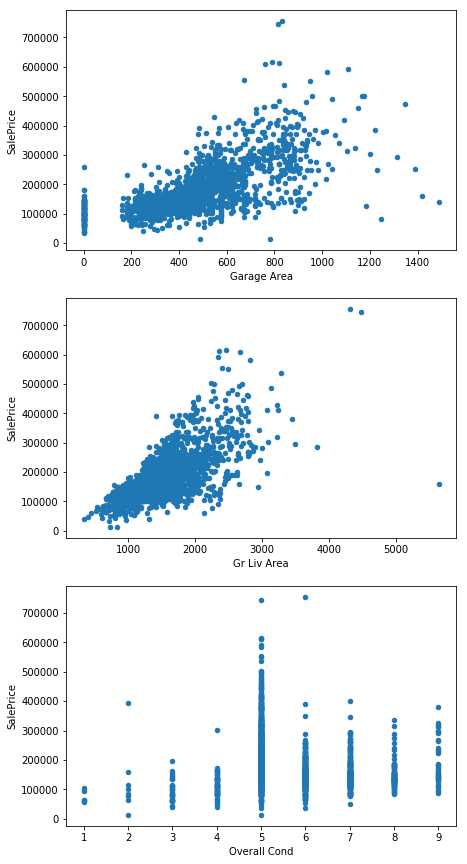

In [13]:
fig = plt.figure(figsize=(7, 15))

ax1 = plt.subplot(3,1,1)
train_houses.plot(x = 'Garage Area', y = 'SalePrice', kind="scatter", ax = ax1)

ax2 = plt.subplot(3,1,2)
train_houses.plot(x = 'Gr Liv Area', y = 'SalePrice', kind="scatter", ax = ax2)

ax3 = plt.subplot(3,1,3)
train_houses.plot(x = 'Overall Cond', y = 'SalePrice', kind="scatter", ax = ax3)

plt.show()

The best interdependence exists for living area. But to confirm that I will calculate the correlation.

In [14]:
train_houses[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr()

,Garage Area,Gr Liv Area,Overall Cond,SalePrice
Garage Area,1.000000,0.489570,-0.152473,0.660196
Gr Liv Area,0.489570,1.000000,-0.136517,0.703783
Overall Cond,-0.152473,-0.136517,1.000000,-0.119200
SalePrice,0.660196,0.703783,-0.119200,1.000000


In [23]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(6, 4))
    cmap = sns.diverging_palette(240, 10,as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

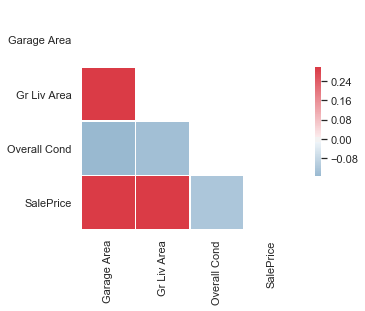

In [24]:
plot_correlation_heatmap(train_houses[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']])

Calculate a0 and a1(intercept_ and coef_ )

\\[\hat{y} = a_1*Gr \ Liv \ Area + a_0\\]

In [26]:
lr = LinearRegression()
lr.fit(train_houses[['Gr Liv Area']], train_houses['SalePrice'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:
a1 = lr.coef_
a0 = lr.intercept_
print(a0,a1)

8767.097215185233 [115.66089909]


\\[\hat{y} = 115.661x_1 + 8767.097\\]

For every square foot more of living area, the price ig going up for about  115 dollars.

In [36]:
results = lr.predict(test[['Gr Liv Area']])
results[:5]

array([189082.43889422, 304165.03348732, 153111.89927768, 120726.84753289,
       168610.45975555])

In [34]:
rmse = np.sqrt(mean_squared_error(results, test['SalePrice']))
rmse

54149.44201320064

#### Multiple linear regression - select best features

In [37]:
mlr_cols = ['Overall Cond', 'Gr Liv Area']
lr.fit(train[cols], train['SalePrice'])
predict_test = lr.predict(test[cols])

In [39]:
rmse = np.sqrt(mean_squared_error(predict_test, test['SalePrice']))
rmse

40888.83287764098